In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset,DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


Load the Dataset

In [2]:
root = os.path.join(os.path.dirname(os.getcwd()), 'UMKC_DS_Capstone/archive/main')

# Define image transformations (resize, convert to tensor, normalize)
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images to 256x256
    transforms.ToTensor(),  # Convert to PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet values, might be useful to pre-trained ResNet
])

# Load the dataset
dataset = datasets.ImageFolder(root= root, transform=transform) #Automatically assigns labels based on folder names

# Create a DataLoader for batching
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Check the classes in the dataset
print("Classes:", dataset.classes)

# Example: Iterate over the DataLoader to check batch shapes
for images, labels in dataloader:
    print("Image batch shape:", images.shape)
    print("Label batch shape:", labels.shape)
    break

Classes: ['noStroke_data', 'stroke_data']
Image batch shape: torch.Size([32, 3, 256, 256])
Label batch shape: torch.Size([32])


Concatenate into 1 tensor

In [3]:
# Create empty lists to store images and labels
all_images = []
all_labels = []

# Loop through the DataLoader and gather all images and labels
for images, labels in dataloader:
    all_images.append(images)
    all_labels.append(labels)

# Concatenate the list of tensors into a single tensor
combined_images = torch.cat(all_images, dim=0)
combined_labels = torch.cat(all_labels, dim=0)

# Print the shape of the combined tensors
print("Combined image tensor shape:", combined_images.shape)
print("Combined label tensor shape:", combined_labels.shape)


Combined image tensor shape: torch.Size([3770, 3, 256, 256])
Combined label tensor shape: torch.Size([3770])


Train, validation and test split

In [4]:
# Define a batch size
batch_size = 16

# Total number of images
total_images = len(combined_images)

# Define split sizes
train_size = int(0.7 * total_images)   # 70% for training
val_size = int(0.15 * total_images)    # 15% for validation
test_size = total_images - train_size - val_size  # Remaining for test

# Split the dataset
train_data, val_data, test_data = random_split(list(zip(combined_images, combined_labels)), [train_size, val_size, test_size])

# Optional: Check the sizes of the splits
print(f"Train set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")
print(f"Test set size: {len(test_data)}")

# Create DataLoader for each split
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Check an example batch from the training set
images, labels = next(iter(train_loader))
print(images.shape, labels.shape)

Train set size: 2639
Validation set size: 565
Test set size: 566
torch.Size([16, 3, 256, 256]) torch.Size([16])


Print random image from the dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4390787..1.7851416].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5161401..1.5816423].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.42195398..1.5473927].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5003501..1.82].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5003501..1.6282789].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.793856

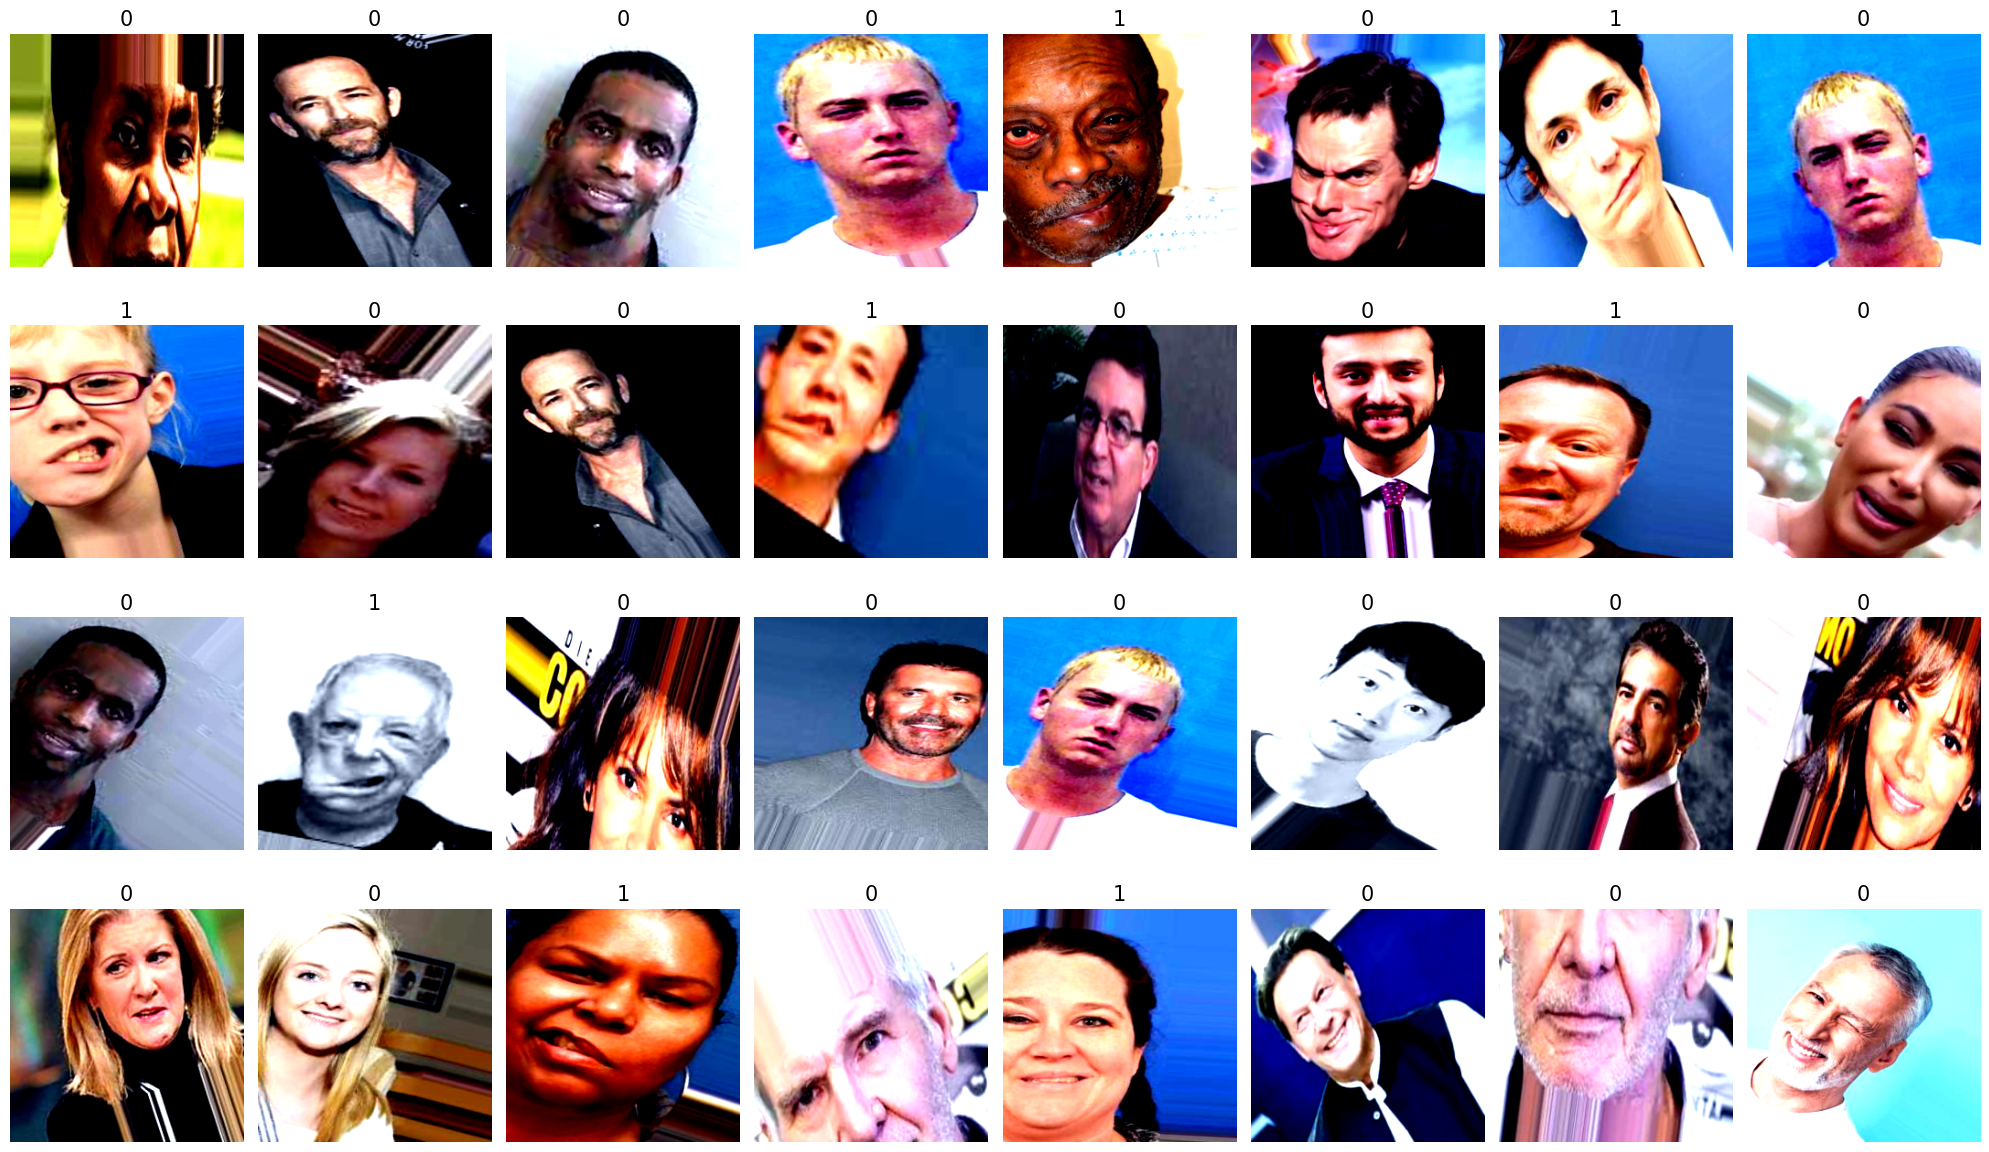

In [5]:
# Function to unnormalize and convert tensor image to numpy for plotting
def imshow(img):
    # Unnormalize: if you applied normalization before, reverse it here
    img = img / 2 + 0.5  # Assuming the image was normalized (this step can change based on your normalization)
    np_img = img.numpy()  # Convert tensor to numpy
    np_img = np.transpose(np_img, (1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
    return np_img

# Create a figure with 4x8 subplots
fig, axes = plt.subplots(4, 8, figsize=(20, 12))
axes = axes.flatten()

# Set a seed for reproducibility and select random 32 indices from the training set
np.random.seed(42)
idx = np.random.choice(len(train_data), size=32, replace=False)

# Loop over the selected indices and plot the images with titles
for i, ix in enumerate(idx):
    axes[i].axis('off')  # Hide axes ticks
    image, label = train_data[ix]  # Get the image and label from the train dataset
    axes[i].imshow(imshow(image))  # Plot the unnormalized image
    axes[i].set_title(str(int(label)), color='black', fontsize=15)  # Set title as label (stroke/no stroke)

# Display the plot
plt.tight_layout()
plt.show()

Set up the ResNet50

In [6]:
from torchvision.models.resnet import ResNet, BasicBlock, Bottleneck

class MyResNet (ResNet):
    def __init__(self, 
                 block = BasicBlock,
                 layers = [2, 2, 2, 2],
                 num_classes = 2):
        super(MyResNet, self).__init__(block,
                                       layers,
                                       num_classes = num_classes)
        self.conv1 = nn.Conv2d(3, 64, kernel_size = 7, stride = 1, padding = 3, bias = False)
        
        '''
        you can modify the layers in this initialization of ResNet if you like
        '''
        
#Choose 1
resnet18 = {
    'block': BasicBlock,
    'layers': [2, 2, 2, 2]
}

resnet34 = {
    'block': BasicBlock,
    'layers': [3, 4, 6, 3]
}

resnet50 = {
    'block' : Bottleneck,
    'layers' : [3, 4, 6, 3]
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MyResNet(**resnet50).to(device)

In [12]:
%pip install torchinfo -q
import torchinfo

Note: you may need to restart the kernel to use updated packages.


Summary of the model

In [7]:
from torchinfo import summary # similiar function to tensorflow/keras summary for torch
summary(model, input_size = (batch_size, 3, 28, 28), device = 'cpu') # (color_channel, 28, 28)

Layer (type:depth-idx)                   Output Shape              Param #
MyResNet                                 [16, 2]                   --
├─Conv2d: 1-1                            [16, 64, 28, 28]          9,408
├─BatchNorm2d: 1-2                       [16, 64, 28, 28]          128
├─ReLU: 1-3                              [16, 64, 28, 28]          --
├─MaxPool2d: 1-4                         [16, 64, 14, 14]          --
├─Sequential: 1-5                        [16, 256, 14, 14]         --
│    └─Bottleneck: 2-1                   [16, 256, 14, 14]         --
│    │    └─Conv2d: 3-1                  [16, 64, 14, 14]          4,096
│    │    └─BatchNorm2d: 3-2             [16, 64, 14, 14]          128
│    │    └─ReLU: 3-3                    [16, 64, 14, 14]          --
│    │    └─Conv2d: 3-4                  [16, 64, 14, 14]          36,864
│    │    └─BatchNorm2d: 3-5             [16, 64, 14, 14]          128
│    │    └─ReLU: 3-6                    [16, 64, 14, 14]          --
│ 

Move to GPU

In [8]:
print("Is GPU available: ", torch.cuda.is_available())

Is GPU available:  True


Set up the training with optimizer

In [15]:
# Define your model, optimizer, and loss function
learning_rate = 1e-3
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)
loss_func = nn.CrossEntropyLoss()

epochs = 100
acc_last_epoch = 0.0
acc_max = 0.0
tolerance = 5  # Number of epochs to wait for improvement before stopping
best_val_loss = float('inf')  # Set the initial best validation loss to infinity
early_stop_counter = 0  # Initialize the early stopping counter

# Lists to store metrics for visualization
train_losses = []
val_losses = []
val_accuracies = []

Train and validate

In [10]:
#Move to GPU
model.to(device)


MyResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1

In [17]:
from tqdm.auto import tqdm


# Training loop with tqdm progress bar
for epoch in range(epochs):
    model.train()
    train_loss = 0
    
    # Initialize the progress bar for training
    with tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{epochs}', unit='batch') as pbar:
        for x, targets in train_loader:
            # Move inputs and targets to the GPU
            x, targets = x.to(device), targets.to(device)
            
            # Forward pass
            outputs = model(x)
            loss = loss_func(outputs, targets)
            
            # Backward pass and optimizer step
            optimizer.zero_grad()  # Clear the gradients
            loss.backward()  # Backpropagation
            optimizer.step()  # Update the weights
            
            # Accumulate training loss
            train_loss += loss.item()
            
            # Update the progress bar description with the current loss
            pbar.set_postfix(loss=loss.item())
            pbar.update()  # Update the progress bar after each batch

    # Average the training loss
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    # Validation loop with tqdm progress bar
    model.eval()
    val_loss = 0
    val_acc = 0
    with torch.no_grad():  # Disable gradient calculation
        with tqdm(total=len(val_loader), desc=f'Validation Epoch {epoch+1}/{epochs}', unit='batch') as pbar_val:
            for x_v, y_v in val_loader:
                # Move validation data to the GPU
                x_v, y_v = x_v.to(device), y_v.to(device)
                yhat = model(x_v)
                yhat = yhat.argmax(dim=-1)

                # Calculate validation loss and accuracy
                val_loss += loss_func(model(x_v), y_v).item()
                val_acc += (yhat == y_v).float().mean().item()

                # Update the progress bar for validation
                pbar_val.update()

    # Average the validation loss and accuracy
    val_loss /= len(val_loader)
    val_acc /= len(val_loader)
    
    # Store validation loss and accuracy
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f'Epoch {epoch+1}/{epochs} - Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss  # Update the best validation loss
        early_stop_counter = 0    # Reset the early stopping counter
        print(f"Validation loss improved, resetting early stopping counter.")
    else:
        early_stop_counter += 1  # Increment early stopping counter
        print(f"No improvement in validation loss for {early_stop_counter} epochs.")
    
    if early_stop_counter >= tolerance:
        print(f"Early stopping triggered after {epoch+1} epochs.")
        break  # Stop the training loop



Validation Epoch 1/100: 100%|██████████| 36/36 [00:04<00:00,  8.90batch/s]


Epoch 1/100 - Training Loss: 0.0544, Validation Loss: 0.0287, Validation Accuracy: 0.9948
Validation loss improved, resetting early stopping counter.


Validation Epoch 2/100: 100%|██████████| 36/36 [00:04<00:00,  8.84batch/s]


Epoch 2/100 - Training Loss: 0.0328, Validation Loss: 0.0251, Validation Accuracy: 0.9913
Validation loss improved, resetting early stopping counter.


Validation Epoch 3/100: 100%|██████████| 36/36 [00:04<00:00,  8.88batch/s]


Epoch 3/100 - Training Loss: 0.0419, Validation Loss: 0.1020, Validation Accuracy: 0.9722
No improvement in validation loss for 1 epochs.


Validation Epoch 4/100: 100%|██████████| 36/36 [00:04<00:00,  8.81batch/s]


Epoch 4/100 - Training Loss: 0.0445, Validation Loss: 0.2097, Validation Accuracy: 0.9514
No improvement in validation loss for 2 epochs.


Validation Epoch 5/100: 100%|██████████| 36/36 [00:04<00:00,  8.84batch/s]


Epoch 5/100 - Training Loss: 0.0404, Validation Loss: 0.0432, Validation Accuracy: 0.9826
No improvement in validation loss for 3 epochs.


Validation Epoch 6/100: 100%|██████████| 36/36 [00:04<00:00,  8.85batch/s]


Epoch 6/100 - Training Loss: 0.0292, Validation Loss: 0.0259, Validation Accuracy: 0.9948
No improvement in validation loss for 4 epochs.


Validation Epoch 7/100: 100%|██████████| 36/36 [00:04<00:00,  8.84batch/s]

Epoch 7/100 - Training Loss: 0.0546, Validation Loss: 0.0379, Validation Accuracy: 0.9861
No improvement in validation loss for 5 epochs.
Early stopping triggered after 7 epochs.


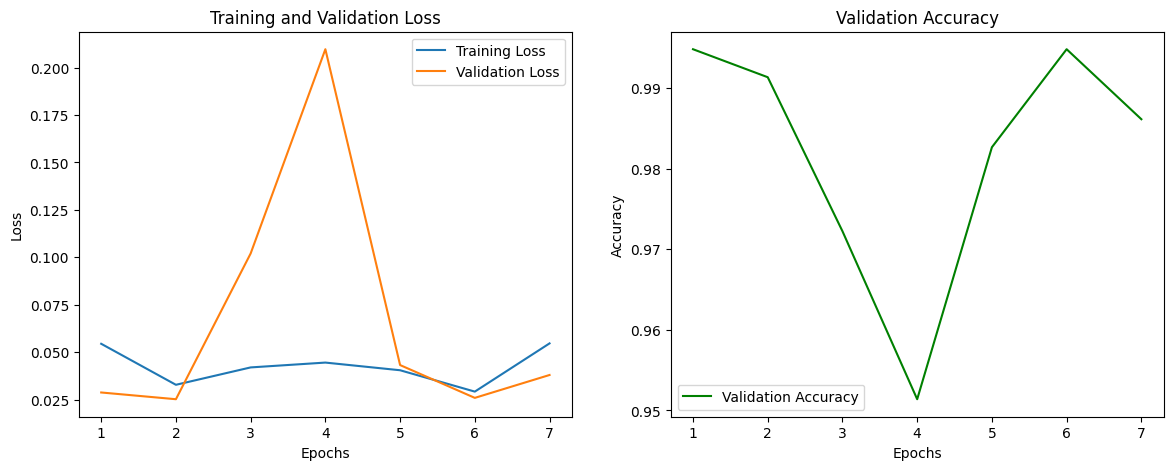

In [18]:
# Visualization

# Create subplots for loss and accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot training and validation loss
ax1.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
ax1.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot validation accuracy
ax2.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy', color='green')
ax2.set_title('Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

# Display the plots
plt.show()

Predict on the test dataset

In [19]:
import torch.nn.functional as F

y_preds = []
for x in tqdm(test_loader):
    with torch.no_grad():
        x = x[0].to(device)
        y_pred = model(x)  # Forward pass through the model
        y_pred = F.softmax(y_pred, dim=1)  # Convert logits to probabilities for binary classification
        y_preds.append(y_pred.cpu().detach().numpy())  # Collect predictions as numpy arrays

# Concatenate predictions into one array
y_preds = np.concatenate(y_preds)

# If using softmax, get the argmax to find the class (0 or 1)
preds = y_preds.argmax(axis=-1).astype(int)

print(preds.shape)  # Should match the number of test samples

100%|██████████| 36/36 [00:02<00:00, 17.28it/s]

(566,)


Test on existing image in google

In [25]:
root = os.path.join(os.path.expanduser("~"), 'Downloads/face_stroke_test5.jpg')

# Define the transformation pipeline (similar to the one used during training)
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize image to match the input size of the model
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize using ImageNet stats
])

# Function to load and preprocess a single image
def predict_image(image_path, model):
    # Load the image
    image = Image.open(image_path).convert('RGB')
    
    # Apply the transformations to the image
    image = transform(image).unsqueeze(0)  # Add batch dimension (1, C, H, W)
    
    # Move the image to the same device as the model (CPU or GPU)
    image = image.to(device)
    
    # Disable gradient calculation for inference
    with torch.no_grad():
        # Forward pass through the model
        output = model(image)
        
        # Apply softmax to convert logits to probabilities
        probabilities = F.softmax(output, dim=1)
        
        # Get the predicted class (0 or 1)
        predicted_class = probabilities.argmax(dim=1).item()

    # Return the predicted class (0 = no stroke, 1 = stroke)
    return predicted_class

# Example usage:
predicted_class = predict_image(image_path = root, model = model)

if predicted_class == 1:
    print("Prediction: Stroke")
else:
    print("Prediction: No Stroke")


Prediction: Stroke


# Citation 

Shuhao Cao. (2023). UMKC 2023 Fall CS 5590 / Math 5555 Optimization. Kaggle. https://kaggle.com/competitions/umkc-2023-fall-cs-5590-math-5555-optimization